# Publishing an openEO process as a service 

In this notebook, we want to show how to create an openEO User Defined Process(UDP). Here, we make use of an apply_dimension process that applies a process to all values along a dimension of a data cube.

The notebook involves a section on creating a concrete datacube, inspecting netCDF downloads, and developing a parameterized version stored as a UDP. 

In [2]:
import json
import openeo
import xarray
import matplotlib.pyplot as plt

from openeo.processes import array_create, array_concat, ProcessBuilder

In [3]:
# Set some defaults for plots
plt.rcParams["figure.figsize"] = [5.0, 3.0]
plt.rcParams["figure.dpi"] = 75

Connect to the openEO Platform backend (at [openeo.cloud](https://openeo.cloud/)) and authenticate with OIDC.

In [4]:
connection = openeo.connect("openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


## Inspect raw data

Load initial data cube with raw `S1_GRD_SIGMA0_ASCENDING` data for a certain spatio-temporal extent.

In [5]:
spatial_extent = {"west": 8.82, "south": 44.40, "east": 8.92, "north": 44.45}
temporal_extent = ["2023-05-01", "2023-07-30"]

s1_raw = connection.load_collection(
    collection_id="S1_GRD_SIGMA0_ASCENDING",
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent,
    bands=["VH", "VV"],
)

Download this data cube synchronously as a netCDF file.

In [6]:
%%time
s1_raw.download("s1sar-raw.nc")

CPU times: user 181 ms, sys: 201 ms, total: 382 ms
Wall time: 30.2 s


In [6]:
ds = xarray.load_dataset("s1sar-raw.nc")
ds

<xarray.Dataset>
Dimensions:  (t: 8, x: 798, y: 558)
Coordinates:
  * t        (t) datetime64[ns] 2023-05-04 2023-05-16 ... 2023-07-15 2023-07-27
  * x        (x) float64 4.857e+05 4.857e+05 4.857e+05 ... 4.936e+05 4.936e+05
  * y        (y) float64 4.922e+06 4.922e+06 4.922e+06 ... 4.916e+06 4.916e+06
Data variables:
    crs      |S1 b''
    VH       (t, y, x) float32 0.03013 0.0584 0.08698 ... 0.0002788 0.002772
    VV       (t, y, x) float32 0.04666 0.0581 0.09845 ... 0.02271 0.02798
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

We got these observations dates:

In [7]:
ds.coords["t"].values

array(['2023-05-04T00:00:00.000000000', '2023-05-16T00:00:00.000000000',
       '2023-05-28T00:00:00.000000000', '2023-06-09T00:00:00.000000000',
       '2023-06-21T00:00:00.000000000', '2023-07-03T00:00:00.000000000',
       '2023-07-15T00:00:00.000000000', '2023-07-27T00:00:00.000000000'],
      dtype='datetime64[ns]')

A quick plot for visual inspection.

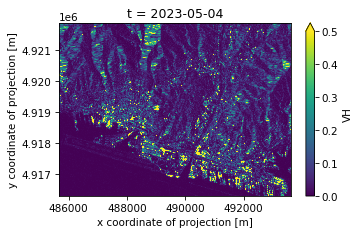

In [8]:
ds["VH"].isel(t=0).plot(vmin=0, vmax=0.5)

This section presented a straightforward example of retrieving and analyzing a `S1_GRD_SIGMA0_ASCENDING` data cube from the backend within a defined area of interest during a specified time frame.

## Collect statistics

As part of more detailed processing within the openEO platform, we'll gather temporal statistics using the `apply_dimension` process and a collection of statistical measures (minimum, maximum, quantiles, ...).

In [9]:
def get_stats(data: ProcessBuilder) -> ProcessBuilder:
    """
    Collect stats for `data` (to be interpreted as an array of values along the "t" dimension).
    We should return a new array with the stats.
    """
    # Put some scalar stats (`min`, `max`, ... return a scalar value) in a new array
    scalar_stats = array_create(
        [
            data.min(),
            data.max(),
            data.mean(),
            data.sd(),
        ]
    )
    # The `quantiles` process returns an array on its own
    quantile_stats = data.quantiles([0.1, 0.5, 0.9])

    # Combine everything in a single array
    return array_concat(array1=scalar_stats, array2=quantile_stats)

In [10]:
s1_stats = s1_raw.apply_dimension(
    process=get_stats,
    dimension="t",
    target_dimension="bands",
)
# Rename band labels, pairing original band names with stat names
s1_stats = s1_stats.rename_labels(
    "bands",
    [
        f"{b}_{s}"
        for b in s1_raw.metadata.band_names
        for s in ["min", "max", "mean", "sd", "q10", "q50", "q90"]
    ],
)

In [12]:
%%time
s1_stats.download("s1sar-stats.nc")

CPU times: user 111 ms, sys: 118 ms, total: 229 ms
Wall time: 38.1 s


In [35]:
import json

with open("sar_metrics2.json", "w") as f:
    json.dump(s1_stats.to_json(), f)

In [11]:
ds = xarray.load_dataset("s1sar-stats.nc").drop_vars("crs")
ds

<xarray.Dataset>
Dimensions:  (x: 798, y: 558)
Coordinates:
  * x        (x) float64 4.857e+05 4.857e+05 4.857e+05 ... 4.936e+05 4.936e+05
  * y        (y) float64 4.922e+06 4.922e+06 4.922e+06 ... 4.916e+06 4.916e+06
Data variables: (12/14)
    VH_min   (y, x) float32 0.007442 0.01634 0.02477 ... 0.0002788 0.0003386
    VH_max   (y, x) float32 0.03604 0.0584 0.08822 ... 0.003115 0.006632
    VH_mean  (y, x) float32 0.01978 0.03318 0.05122 ... 0.001801 0.003237
    VH_sd    (y, x) float32 0.009419 0.01686 0.0247 ... 0.0009503 0.00193
    VH_q10   (y, x) float32 0.007442 0.01634 0.02477 ... 0.0002788 0.0003386
    VH_q50   (y, x) float32 0.01642 0.02946 0.04615 ... 0.001851 0.003168
    ...       ...
    VV_max   (y, x) float32 0.2145 0.352 0.4421 ... 0.02347 0.02271 0.04126
    VV_mean  (y, x) float32 0.09626 0.1365 0.1872 ... 0.01012 0.01103 0.01548
    VV_sd    (y, x) float32 0.05409 0.09378 0.1112 ... 0.006371 0.006519 0.01286
    VV_q10   (y, x) float32 0.03823 0.0581 0.09845 ... 0.003309 0.002925
    VV_q50   (y, x) float32 0.08684 0.1051 0.1579 ... 0.008462 0.009489 0.01156
    VV_q90   (y, x) float32 0.2145 0.352 0.4421 ... 0.02347 0.02271 0.04126
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

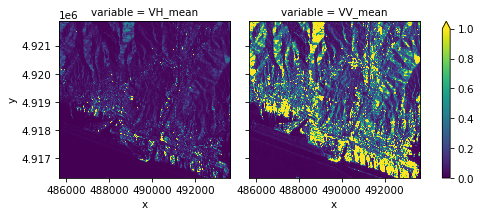

In [12]:
ds[["VH_mean", "VV_mean"]].to_array().plot.imshow(col="variable", vmin=0, vmax=1)

## Build S1 SAR stats UDP

Suppose we want to save the above-described algorithm as a User-Defined-Process(UDP). Therefore, in this section, we define the input parameters, define the earlier workflow and then save it as a process. 

The only limitation of this approach, is that your workflow needs to be defined as a single process graph. So workflows that require multiple openEO invocations or complex parameter preprocessing won't work yet. However, thanks to the flexibility of openEO and the ability to include custom code as a UDF, a lot of algorithms can already be defined in a single openEO graph.

In [13]:
import openeo
from openeo.api.process import Parameter
from openeo.processes import array_create, array_concat

Let us define the UDP parameters to allow specifying the spatio-temporal extent.

To make a service available to users, we might want to replace certain fixed values in your process graph with parameters that can be set by the user of your process. This provides you with a parameterised UDP.

In [14]:
temporal_extent = Parameter(
    name="temporal_extent",
    description="The time window to calculate the stats for.",
    schema={"type": "array", "subtype": "temporal-interval"},
    default=["2023-05-01", "2023-07-30"],
)
spatial_extent = Parameter(
    name="spatial_extent",
    description="The spatial extent to calculate the stats for.",
    schema={"type": "object", "subtype": "bounding-box"},
    default={"west": 8.82, "south": 44.40, "east": 8.92, "north": 44.45},
)

In [15]:
s1_raw = connection.load_collection(
    collection_id="S1_GRD_SIGMA0_ASCENDING",
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent,
    bands=["VH", "VV"],
)

# Unlike above, where we defined the `apply_dimension` process
# through a regular python function, we do it here compactily with a single "lambda".
s1_stats = s1_raw.apply_dimension(
    process=lambda data: array_concat(
        array1=array_create([data.min(), data.max(), data.mean(), data.sd()]),
        array2=data.quantiles([0.1, 0.5, 0.9]),
    ),
    dimension="t",
    target_dimension="bands",
)
# Rename band labels, pairing original band names with stat names
s1_stats = s1_stats.rename_labels(
    "bands",
    [
        f"{b}_{s}"
        for b in s1_stats.metadata.band_names
        for s in ["min", "max", "mean", "sd", "q10", "q50", "q90"]
    ],
)

Store this parameterized data cube as a UDP

In [16]:
udp_sar = connection.save_user_defined_process(
    user_defined_process_id="s1_stats",
    process_graph=s1_stats,
    parameters=[temporal_extent, spatial_extent],
    summary="S1 SAR stats",
    description="Calculate S1 SAR stats (min, max, mean, sd, q10, q50, q90)",
    public=True,
)

When saving a process, please note that saved processes are private by default, nonetheless can be used multiple times by an individual. Therefore, to share with a large audience, you will need a public URL that can be achieved once the process is saved as public.

In [20]:
public_url, _ = [
    l["href"] for l in udp_sar.describe()["links"] if l["rel"] == "canonical"
]

## Use saved UDP

Now, let’s evaluate our freshly created user-defined processes "s1_stats". We can use `datacube_from_process()` to create a DataCube from this process and only have to provide concrete temporal and spatial extents

In [21]:
spatial_extent = {"west": 8.82, "south": 44.40, "east": 8.92, "north": 44.45}
temporal_extent = ["2023-05-01", "2023-07-30"]

In [23]:
sar = connection.datacube_from_process(
    "s1_stats",
    namespace=public_url,
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent,
)

In [26]:
%%time
sar.download("s1sar.nc")

CPU times: user 169 ms, sys: 138 ms, total: 307 ms
Wall time: 1min 29s


In [28]:
ds = xarray.load_dataset("s1sar.nc").drop_vars("crs")
ds

<xarray.Dataset>
Dimensions:  (x: 798, y: 558)
Coordinates:
  * x        (x) float64 4.857e+05 4.857e+05 4.857e+05 ... 4.936e+05 4.936e+05
  * y        (y) float64 4.922e+06 4.922e+06 4.922e+06 ... 4.916e+06 4.916e+06
Data variables: (12/14)
    VH_min   (y, x) float32 0.007442 0.01634 0.02477 ... 0.0002788 0.0003386
    VH_max   (y, x) float32 0.03604 0.0584 0.08822 ... 0.003115 0.006632
    VH_mean  (y, x) float32 0.01978 0.03318 0.05122 ... 0.001801 0.003237
    VH_sd    (y, x) float32 0.009419 0.01686 0.0247 ... 0.0009503 0.00193
    VH_q10   (y, x) float32 0.007442 0.01634 0.02477 ... 0.0002788 0.0003386
    VH_q50   (y, x) float32 0.01642 0.02946 0.04615 ... 0.001851 0.003168
    ...       ...
    VV_max   (y, x) float32 0.2145 0.352 0.4421 ... 0.02347 0.02271 0.04126
    VV_mean  (y, x) float32 0.09626 0.1365 0.1872 ... 0.01012 0.01103 0.01548
    VV_sd    (y, x) float32 0.05409 0.09378 0.1112 ... 0.006371 0.006519 0.01286
    VV_q10   (y, x) float32 0.03823 0.0581 0.09845 ... 0.003309 0.002925
    VV_q50   (y, x) float32 0.08684 0.1051 0.1579 ... 0.008462 0.009489 0.01156
    VV_q90   (y, x) float32 0.2145 0.352 0.4421 ... 0.02347 0.02271 0.04126
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

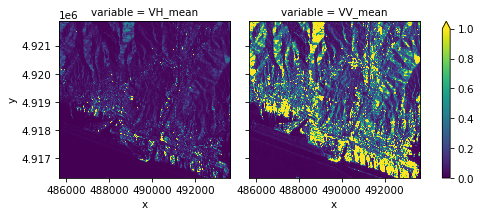

In [29]:
ds[["VH_mean", "VV_mean"]].to_array().plot.imshow(col="variable", vmin=0, vmax=1)

## Publishing your service online

Once the UDP defined above is saved within the openEO platform, a user also has the option to add this service to the openEO Marketplace. 
To register a User Defined Process (UDP), you must have a public URL for your service. You'll also need to provide the saved process ID, which can be located within the public URL.

A detailed documentation on the process can be followed here:
[https://documentation.dataspace.copernicus.eu/Applications/PlazaDetails/ManageService.html#register-and-publish-your-service](https://documentation.dataspace.copernicus.eu/Applications/PlazaDetails/ManageService.html#register-and-publish-your-service)